# Présentation de la Knowledge Distillation by Octo

## Imports

In [7]:
import torch
import numpy as np
import pandas as pd
import copy
import sklearn.metrics
import os
import matplotlib.pyplot as plt

# set path the folder before
os.chdir("/Users/camille.hascoet/Documents/greenai/src/hale/clean/")

from green_ai.datasets import (
    get_cifar10,
    plot_cifar_images,
    make_validation_loader,
    is_balanced,
)

from green_ai.utils import (
    calculate_convlayer_out_size,
)

from typing import Tuple, List

import codecarbon


seed = 42
data_path = "/Users/camille.hascoet/Documents/greenai/src/hale/sandbox/data"

## Création des dataloaders

Files already downloaded and verified
Files already downloaded and verified


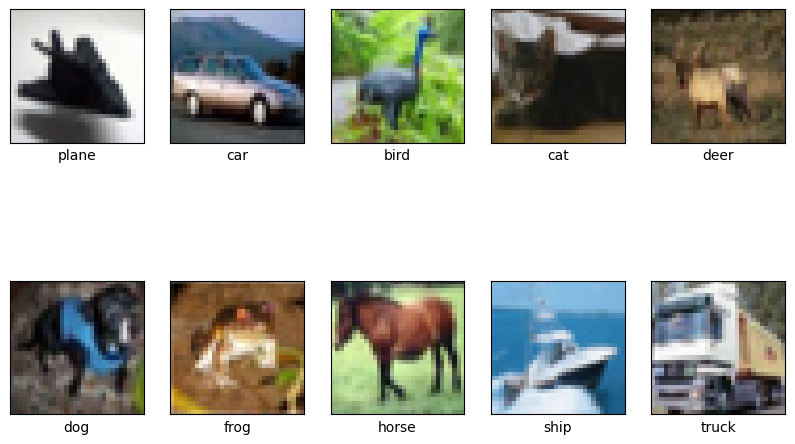

In [8]:
trainloader, testloader = get_cifar10(path=data_path, batch_size=32)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

plot_cifar_images(classes=classes, trainloader=trainloader)

trainloader, validloader = make_validation_loader(
    trainloader, validation_size=0.20, random_seed=seed * 2
)

In [ ]:
assert is_balanced(trainloader, epsilon=0.1)  # check if the dataset is balanced
assert is_balanced(validloader, epsilon=0.1)  # check if the dataset is balanced

# La classe ConvNet que nous utiliserons pour créer nos différents modèles

In [9]:
class ConvNet(torch.nn.Module):
    """
    Convolutional Neural Network model for image classification.

    Args:
        height (int): The height of the input image.
        width (int): The width of the input image.
        channels (int): The number of channels in the input image.
        num_classes (int): The number of classes for classification.
        extracted_features (int, optional): The number of extracted features in the convolutional layers. Defaults to 128.
        kernel_size (int, optional): The size of the convolutional kernel. Defaults to 3.
        stride (int, optional): The stride of the convolutional kernel. Defaults to 1.
        padding (int, optional): The padding of the convolutional kernel. Defaults to 0.
    """

    def __init__(
        self,
        height: int,
        width: int,
        channels: int,
        num_classes: int,
        extracted_features: int = 128,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 0,
    ):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=channels,
            out_channels=extracted_features // 2,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        height, width = calculate_convlayer_out_size(
            height=height,
            width=width,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=1,
            pooling_kernel_size=2,
            pooling_stride=2,
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=extracted_features // 2,
            out_channels=extracted_features,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        height, width = calculate_convlayer_out_size(
            height=height,
            width=width,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=1,
            pooling_kernel_size=2,
            pooling_stride=2,
        )
        self.bn1 = torch.nn.BatchNorm2d(extracted_features // 2)
        self.bn2 = torch.nn.BatchNorm2d(extracted_features)

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(
            in_features=extracted_features * height * width, out_features=64
        )
        self.fc2 = torch.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # flatten
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def train_model(
    model: torch.nn.Module,
    trainloader: torch.utils.data.DataLoader,
    validloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 10,
    patience: int = 3,
):
    """
    Trains a given model using the provided data loaders and optimization parameters.

    Args:
        model (torch.nn.Module): The model to be trained.
        trainloader (torch.utils.data.DataLoader): The data loader for the training set.
        validloader (torch.utils.data.DataLoader): The data loader for the validation set.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        num_epochs (int, optional): The number of epochs to train the model (default is 10).
        patience (int, optional): The number of epochs to wait for improvement in validation accuracy before early stopping (default is 3).

    Returns:
        tuple: A tuple containing the trained model, training losses, validation losses, and carbon emissions.

    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
    tracker.start()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = validloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience = 3
                else:
                    patience -= 1
                    if patience == 0:
                        emissions = tracker.stop()
                        print(f"Early stopping, best val accuracy: {best_acc:.4f}")
                        model.load_state_dict(best_model_wts)
                        return model, train_losses, val_losses, emissions * 1000

            if phase == "val":
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

    emissions = tracker.stop()

    print(f"Best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, emissions * 1000

## Variables de base

In [11]:
EPOCHS = 15
HEIGHT = 32
WIDTH = 32
CHANNELS = 3
N_CLASSES = 10

## Training du teacher

In [12]:
teacher = ConvNet(height=32, width=32, channels=3, num_classes=10)
teacher = teacher.to("cuda" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(teacher.parameters(), lr=0.001)

teacher, train_losses, val_losses, teacher_emissions = train_model(
    teacher, trainloader, validloader, criterion, optimizer, num_epochs=EPOCHS
)

## Training du student, sans distillation pour pouvoir comparer plus tard

In [13]:
student = ConvNet(
    height=HEIGHT,
    width=WIDTH,
    channels=CHANNELS,
    num_classes=N_CLASSES,
    extracted_features=32,
)
student = student.to("cuda" if torch.cuda.is_available() else "cpu")

criterion_student = torch.nn.CrossEntropyLoss()

optimizer_student = torch.optim.Adam(student.parameters(), lr=0.001)

student, train_losses_student, val_losses_student, student_emissions = train_model(
    student, trainloader, validloader, criterion, optimizer, num_epochs=EPOCHS
)

# Evaluation des deux premiers modèles

In [9]:
def evaluate_model(
    model: torch.nn.Module,
    testloader: torch.utils.data.DataLoader,
    carbon_track: bool = True,
):
    """
    Evaluates a given model on a test dataset and calculates the test accuracy and carbon emissions.

    Args:
        model (torch.nn.Module): The model to evaluate.
        testloader (torch.utils.data.DataLoader): The test data loader.
        carbon_track (bool, optional): Flag to enable/disable carbon emissions tracking.
            Defaults to True.

    Returns:
        tuple: A tuple containing the test accuracy and carbon emissions (if carbon_track is True).

    """
    model.eval()
    running_corrects = 0

    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(testloader.dataset)

    if carbon_track:

        tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()

        for inputs, labels in testloader:
            outputs = model(inputs)

        emissions = 1000 * tracker.stop() / len(testloader.dataset)

    else:

        emissions = None

    return test_acc, emissions

In [ ]:
teacher_acc, teacher_inference_emissions = evaluate_model(teacher, testloader)
print(f"Teacher model test accuracy: {teacher_acc:.4f}")
student_acc, student_inference_emissions = evaluate_model(student, testloader)
print(f"Student model test accuracy: {student_acc:.4f}")

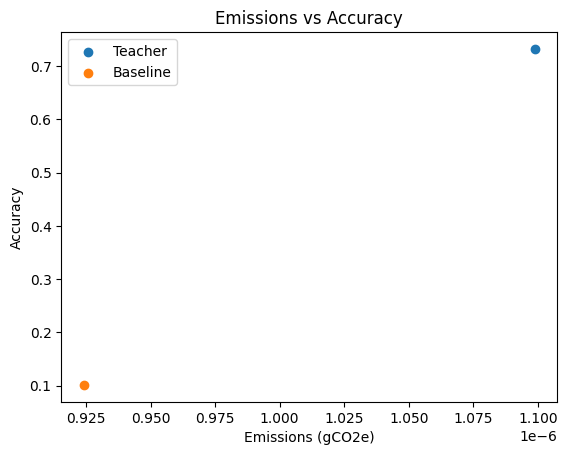

In [11]:
plt.scatter(teacher_inference_emissions, teacher_acc, label="Teacher")
plt.scatter(student_inference_emissions, student_acc, label="Baseline")

plt.xlabel("Emissions (gCO2e)")
plt.ylabel("Accuracy")

plt.legend()

plt.title("Emissions vs Accuracy")

plt.show()

# Knowledge Distillation : Les fonctions dont on a besoin

## Calcul de la loss

In [12]:
def distillation_loss(
    student_outputs,
    teacher_outputs,
    true_labels,
    criterion,
    T: float = 1.0,
    alpha: float = 0.5,
):
    """
    Calculates the distillation loss for knowledge distillation.

    Args:
        student_outputs (torch.Tensor): The output logits of the student model.
        teacher_outputs (torch.Tensor): The output logits of the teacher model.
        true_labels (torch.Tensor): The true labels for the input data.
        criterion: The loss criterion used for the student model.
        T (float, optional): The temperature parameter for distillation. Defaults to 1.0.
        alpha (float, optional): The weight given to the teacher loss. Defaults to 0.5.

    Returns:
        torch.Tensor: The calculated distillation loss.

    """

    # Calculate the soft targets using softmax with temperature T
    soft_targets = torch.nn.functional.softmax(teacher_outputs / T, dim=1)

    # Calculate the soft probabilities using log softmax with temperature T
    soft_prob = torch.nn.functional.log_softmax(student_outputs / T, dim=1)

    # Calculate the teacher loss
    teacher_loss = (
        torch.sum(soft_targets * (soft_targets.log() - soft_prob))
        / soft_prob.size()[0]
        * T**2
    )

    # Calculate the student loss using the provided criterion
    student_loss = criterion(student_outputs, true_labels)

    # Calculate the overall loss as a weighted sum of teacher loss and student loss
    loss = alpha * teacher_loss + (1 - alpha) * student_loss

    return loss

## Nouvelle loop prenant en compte la KD

In [13]:
def knowledge_distillation(
    teacher: torch.nn.Module,
    student: torch.nn.Module,
    trainloader: torch.utils.data.DataLoader,
    validloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 10,
    patience: int = 3,
    T: float = 2.0,
    alpha: float = 0.5,
):
    """
    Perform knowledge distillation from a teacher model to a student model.

    Args:
        teacher (torch.nn.Module): The teacher model.
        student (torch.nn.Module): The student model.
        trainloader (torch.utils.data.DataLoader): The training data loader.
        validloader (torch.utils.data.DataLoader): The validation data loader.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        num_epochs (int, optional): The number of epochs to train for. Defaults to 10.
        patience (int, optional): The number of epochs to wait for improvement in validation accuracy before early stopping. Defaults to 3.
        T (float, optional): The temperature for distillation. Defaults to 2.0.
        alpha (float, optional): The weight for distillation loss. Defaults to 0.5.

    Returns:
        torch.nn.Module: The trained student model.
        list: The training losses.
        list: The validation losses.
        float: The emissions in grams of CO2 equivalent.

    """
    best_model_wts = copy.deepcopy(student.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
    tracker.start()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                student.train()
                dataloader = trainloader
            else:
                student.eval()
                dataloader = validloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    with torch.no_grad():
                        teacher_outputs = teacher(inputs)
                    student_outputs = student(inputs)
                    loss = distillation_loss(
                        student_outputs, teacher_outputs, labels, criterion, T, alpha
                    )
                    _, preds = torch.max(student_outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(student.state_dict())
                    patience = 3
                else:
                    patience -= 1
                    if patience == 0:
                        emissions = tracker.stop()
                        print(f"Early stopping, best val accuracy: {best_acc:.4f}")
                        student.load_state_dict(best_model_wts)
                        return student, train_losses, val_losses, emissions * 1000

            if phase == "val":
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

    emissions = tracker.stop()

    print(f"Best val Acc: {best_acc:4f}")

    student.load_state_dict(best_model_wts)

    return student, train_losses, val_losses, emissions * 1000

## Training en utilisant la KD

In [ ]:
distilled_student = ConvNet(
    height=HEIGHT,
    width=WIDTH,
    channels=CHANNELS,
    num_classes=N_CLASSES,
    extracted_features=32,
)

optimizer_distilled_student = torch.optim.Adam(distilled_student.parameters(), lr=0.001)

(
    distilled_student,
    train_losses_distilled_student,
    val_losses_distilled_student,
    distilled_student_emissions,
) = knowledge_distillation(
    teacher,
    distilled_student,
    trainloader,
    validloader,
    criterion,
    optimizer_distilled_student,
    num_epochs=EPOCHS,
)

# Comparaison des résultats

In [15]:
distilled_student_acc, distilled_student_inference_emissions = evaluate_model(
    distilled_student, testloader, carbon_track=False
)
distilled_student_inference_emissions = student_inference_emissions

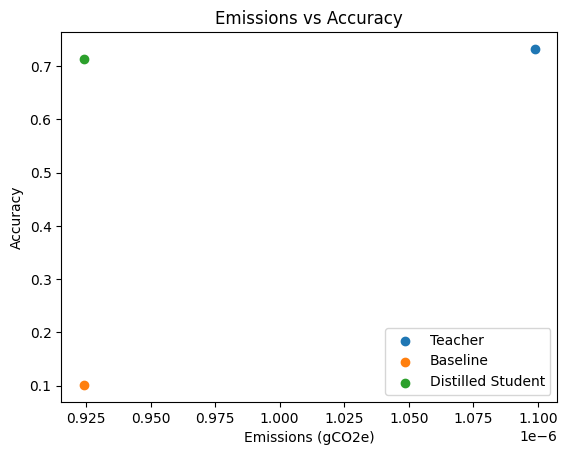

In [16]:
plt.scatter(teacher_inference_emissions, teacher_acc, label="Teacher")
plt.scatter(student_inference_emissions, student_acc, label="Baseline")
plt.scatter(
    distilled_student_inference_emissions,
    distilled_student_acc,
    label="Distilled Student",
)

plt.xlabel("Emissions (gCO2e)")
plt.ylabel("Accuracy")

plt.legend()

plt.title("Emissions vs Accuracy")

plt.show()

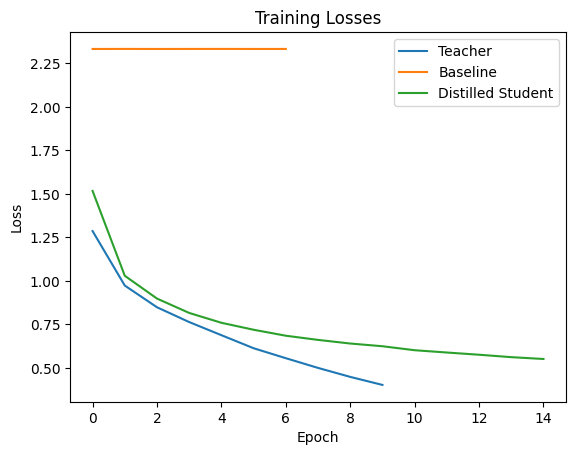

In [17]:
plt.plot(train_losses, label="Teacher")
plt.plot(train_losses_student, label="Baseline")
plt.plot(train_losses_distilled_student, label="Distilled Student")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("Training Losses")

plt.show()

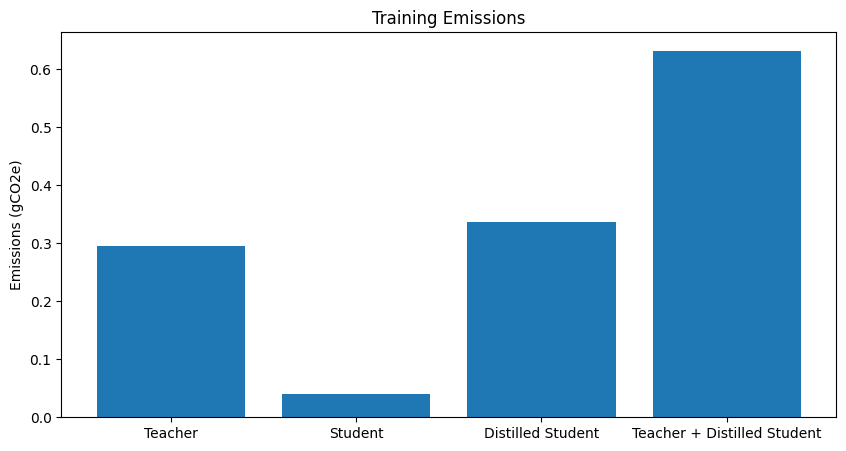

In [18]:
plt.figure(figsize=(10, 5))

emissions = [
    teacher_emissions,
    student_emissions,
    distilled_student_emissions,
    teacher_emissions + distilled_student_emissions,
]
models = ["Teacher", "Student", "Distilled Student", "Teacher + Distilled Student"]

plt.bar(models, emissions)

plt.ylabel("Emissions (gCO2e)")
plt.title("Training Emissions")

plt.show()

In [14]:
import os


def get_model_size(model: torch.nn.Module) -> int:
    """
    Calculates the size of a PyTorch model in bytes.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        int: The size of the model in bytes.

    """
    torch.save(model.state_dict(), "model.pth")
    size = os.path.getsize("model.pth")
    os.remove("model.pth")
    return size

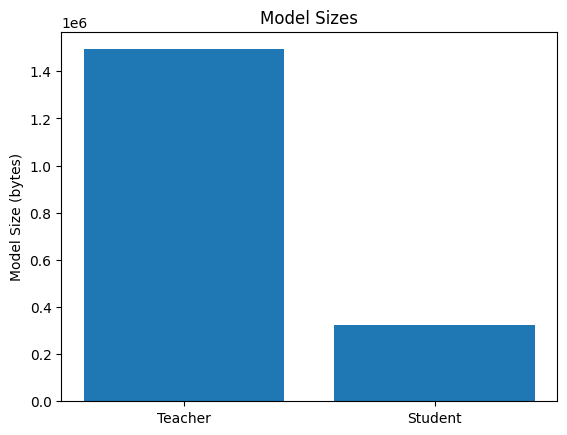

In [15]:
model_sizes = [
    get_model_size(teacher),
    get_model_size(student),
]

models = ["Teacher", "Student"]

plt.bar(models, model_sizes)

plt.ylabel("Model Size (bytes)")
plt.title("Model Sizes")

plt.show()

# Exemple avec la librairie *green_ai Made by Octo*

In [24]:
from green_ai.experimentation import torch_Experimentation

from green_ai.models import small_ConvModel, Student

In [25]:
gr_teacher = small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=CHANNELS,
    out_features=N_CLASSES,
    out_channels=128,
)

gr_student = small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=CHANNELS,
    out_features=N_CLASSES,
    out_channels=24,
)

gr_student_distilled = Student(
    teacher=gr_teacher,
    student=copy.deepcopy(gr_student),
    classification=True,
    temperature=2.0,
    teacher_weight=0.5,
)

teacher_optimizer = torch.optim.Adam(gr_teacher.parameters(), lr=0.001)
student_optimizer = torch.optim.Adam(gr_student.parameters(), lr=0.001)
student_distilled_optimizer = torch.optim.Adam(
    gr_student_distilled.student.parameters(), lr=0.001
)

In [ ]:
log_file = "logs/GREAI.csv"
log_id = "KD"

experiment = torch_Experimentation(
    models=[gr_teacher, gr_student, gr_student_distilled],
    optimizers=[teacher_optimizer, student_optimizer, student_distilled_optimizer],
    model_names=["teacher", "student", "student_distilled"],
    train_loader=trainloader,
    validation_set=True,
    validation_size=0.2,
    test_loader=testloader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    epochs=EPOCHS,
    metric_fn=sklearn.metrics.accuracy_score,
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_file=log_file,
    log_id=log_id,
)

experiment.run_experiment()

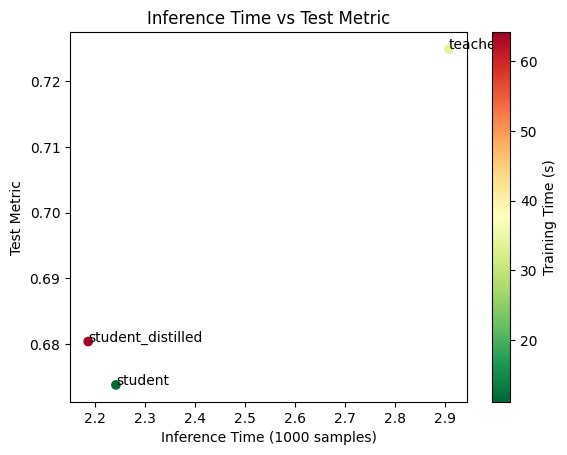

{'teacher': {'train': {'time': 33.76480131149292, 'carbon': 0.013098650226225838}, 'test': {'loss': 0.8407055130004882, 'metric': 0.7249}, 'inference': {'time': 2.9069115209579466, 'carbon': 0.01225567472475148}}, 'student': {'train': {'time': 11.1786825021108, 'carbon': 0.0035481399397010375}, 'test': {'loss': 0.9460396443367004, 'metric': 0.6738}, 'inference': {'time': 2.2416627359390255, 'carbon': 0.00949989913575662}}, 'student_distilled': {'train': {'time': 64.15260990460713, 'carbon': 0.0246116131425489}, 'test': {'loss': 0.9382332655906678, 'metric': 0.6804}, 'inference': {'time': 2.1861939811706543, 'carbon': 0.009258312995811598}}}


In [ ]:
experiment.plot_inference_vs_score()

print(experiment.get_results())